<a href="https://colab.research.google.com/github/Absinthe31/ProgettoINFORET/blob/develop/Matches_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
#!chmod +x mini.sh
#!bash ./mini.sh -b -f -p /usr/local
#!conda install -q -y jupyter
#!conda install -q -y google-colab -c conda-forge
#!python -m ipykernel install --name "py38" --user
#!sudo apt install python3-pip

In [ ]:
#import sys
#print("version:", sys.version)

In [ ]:
#NON SONO ANCORA RIUSCITO A FAR ANDARE PYTHON 3.8

#!pip install git+https://github.com/JustAnotherArchivist/snscrape.git

In [ ]:
!pip install scrapy --quiet
!pip install snscrape --quiet
!pip install selenium --quiet
!pip install pyvirtualdisplay --quiet
#!pip install nltk --quiet
!pip install deep_translator --quiet
!pip install textblob --quiet
!pip install unidecode --quiet
!pip install Levenshtein --quiet

#!pip install -r requirements.txt

!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

In [ ]:
!sudo apt-get -qq update
!sudo apt-get -qq -y install xvfb

In [ ]:
cd /content/drive/MyDrive/Github/ProgettoINFORET/skysport

/content/drive/.shortcut-targets-by-id/1iFtUtwFYEJ0mA0_-8G-WnwkDqMpE003B/ProgettoINFORET/skysport


In [ ]:
import selenium
import snscrape.modules.twitter as sntwitter
import datetime
import numpy as np
import pandas as pd
import requests
import spacy
import json
import copy
import os
import time
import re
import nltk
import urllib.request
import Levenshtein as lev

from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from pyvirtualdisplay import Display
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException, ElementClickInterceptedException
from nltk.corpus import stopwords
from string import punctuation, digits
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm
from textblob import TextBlob
from textblob.taggers import NLTKTagger

from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer


nlp = spacy.load("en_core_web_sm")


        
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
#nltk.download('movie_reviews')
translator = GoogleTranslator(source='it', target='en')
#os.chmod("./chromedriver", 0o777)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
!apt -qq install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 17 not upgraded.
Need to get 95.1 MB of archives.
After this operation, 319 MB of additional disk space will be used.
Selecting previously unselected package chromium-codecs-ffmpeg-extra.
(Reading database ... 123949 files and directories currently installed.)
Preparing to unpack .../chromium-codecs-ffmpeg-extra_107.0.5304.87-0ubuntu11.18.04.1_amd64.deb ...
Unpacking chromium-codecs-ffmpeg-extra (107.0.5304.87-0ubuntu11.18.04.1) ...
Selecting previously unselected package 

# Data processing

## Articles scraping

In [ ]:
#!rm scrapedUrls.json
#!scrapy crawl titles -o scrapedUrls.json

## Scraping teams and players stats

In [ ]:
dataframe = pd.read_json(path_or_buf='./scrapedUrls.json')

token = '9592c1c916514c54a712c48fe03a14b4'

key = "8e5a90e4536f74e302656ba3f717456413faa66a1804d165187a7b398ca66086"

uri2 = f"https://apiv3.apifootball.com/?action=get_events&from=2020-08-10&to=2021-07-10&league_id=207&APIkey={key}"

matches = requests.get(uri2)

print(matches) 

uri = 'https://api.football-data.org/v4/competitions/SA/teams?season=2020'
headers = { 'X-Auth-Token': token}

teams = requests.get(uri, headers=headers)

xteams = copy.deepcopy(teams)
    

teams = [team['shortName'] for team in teams.json()['teams']]

teams_dict = { i : pd.DataFrame() for i in teams }


def adjust_name(name):

    return name.split(' ')[0].lower()

for team in teams:
    
    teams_dict[team] = dataframe[[(adjust_name(team) in x) for x in dataframe.tags]]

<Response [200]>


In [ ]:

def remove_prefix(string):
    return string.replace("AC ", "").replace(" Calcio", '').replace("FC ", "").replace("Hellas ","").replace("nazionale", "")


def remove_adds(string):

    if '+' in string:

        return string.split("+")[0]

    elif '-' in string:

        return string.split("-")[0]

    else:

        return string

    
def get_numbers(string): 

    listx =  ' '.join([remove_adds(n) for n in string.split(' ')])
    sentence = listx
    #print('LIST')
    #print(listx,'\n')
    numbers = [float(s) for s in re.findall(r'-?\d+\.?\d*', sentence)]
    #print('NUMBERS')
    #print(numbers)
    numbers = [(int(n) if n.is_integer() else n) for n in numbers]
    #print(numbers)
    try:
        if(len(numbers) == 9) or (len(numbers) == 11):
            numbers[2] /= 1000
        else:
            numbers[3] /= 1000
    except IndexError:
        pass
    numbers = [n for n in numbers if n<1000]

    return numbers


def get_team_player(string, leaderboard):
    name = []
    for team in leaderboard.Team:
        if team in string:
            string = string.replace(team,'')
            name.append(team)
            #break

    return (string,name)

def get_table(i,l,leaderboard,driver):
    try:
      pagination = driver.find_elements('xpath',"//ul//li[contains(@class,'page')]")
      pagination[i].click()


    except NoSuchElementException:
      print("No such element get_table")
      return True

    #except ElementClickInterceptedException:
    #  print("Element click intercepted get_table")
    #  pass


    j = 1


    while True:
        try:
            b = driver.find_element('xpath',f"//div[@id='league-players']/table/tbody/tr[{j}]").text

            (c, team) = get_team_player(b,leaderboard)
            players = [str for str in c.split(' ') if (str.isalpha())]
            
            c = get_numbers(b)
            c.insert(1, ' '.join(players))
            c.insert(2, team)
        
            l.append(c) 
            #print(c)
            j+=1
            
            #time.sleep(2)
        except NoSuchElementException:
            break

In [ ]:
#display = Display(size=(1920, 1080))  
#display.start()
url = 'https://understat.com/league/Serie_A/2020'

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

options = webdriver.ChromeOptions()
options.add_argument('--disable-dev-shm-usage')    
options.add_argument('--headless')
options.add_argument('--no-sandbox')      
#options.binary_location = "/usr/bin/google-chrome-stable"
#chrome_driver_binary = "./chromedriver"
#d = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()),options = options)
d = webdriver.Chrome('chromedriver',options=options)
d.get(url)
def get_tables(s_date, e_date,driver, leaderboard_only):
    actions = ActionChains(driver) 
    driver = webdriver.Chrome('chromedriver',options = options)
    driver.set_window_size(1920, 1080)
    driver.get(url)

    driver.find_element('name','date-start').click()


    sDate  = driver.find_element('name','date-start') # set start date input element into variable
    sDate.clear() #clear existing entry
    sDate.send_keys(s_date) #add custom entry


    driver.find_element('name','date-end').click()

    eDate  = driver.find_element('name','date-end') # set start date input element into variable
    eDate.clear() #clear existing entry

    eDate.send_keys(e_date) #add custom entry
    eDate.send_keys(Keys.TAB)
    #actions = actions.send_keys(Keys.TAB)
    #actions.perform()

    #element = driver.find_element('xpath',"//body")
    #element.send_keys(Keys.TAB)


    #SEMBRA FUNZIONARE  --  NON è VERO, ORA DA TIMEOUT EXCEPTION, PROVO A FIXARE -- NON SO, MI SA CHE L'ECCEZIONE è CAUSATA DAL FATTO CHE ANCHE ASPETTANDO 10 SECONDI
    #COMUNQUE L'ELEMENTO NON C'è, PROVO CON 15 SECONDI MA BOH, NON SO -- BOH, NON VA NEMMENO COSì, SEMBRA CHE PROPRIO NON VIENE CARICATO L'ELEMENTO

    try:

      p = WebDriverWait(driver, 15).until( EC.visibility_of_element_located((By.XPATH, "//div[@id='league-chemp']/table/thead/tr"))).text


    except TimeoutException:
      print('ERRORE')
      #Non saprei come gestire se non c'è l'elemento dopo 15 secondi, perchè anche ri-eseguendo può essere che non c'è ancora
      pass


    playersHeader = driver.find_element('xpath',"//div[@id='league-players']/table/thead/tr").text


    i = 1
    l = [] 

    while True:
        try:
            b = driver.find_element('xpath',f"//div[@id='league-chemp']/table/tbody/tr[{i}]").text
            
            teams = [str for str in b.split(' ') if (str.isalpha())]
            #print(teams)
            #not "abc" in s
            
            c = get_numbers(b)
            c.insert(1, ' '.join(teams))
            
            l.append(c) 

            #print(l)
            #leaderboard.loc[i] = b.split(' ')
            i+=1
            
        except NoSuchElementException:
            break

    leaderboard = pd.DataFrame(l, columns=p.split(' '))
    leaderboard = leaderboard.set_index('№')
    leaderboard['W'] = leaderboard['W'] * 1000
    #print('CLASSIFICA')
    #print(leaderboard)


    if leaderboard_only:
      driver.quit()
      return leaderboard

    driver.find_element('name','players-date-start').click()


    sDate  = driver.find_element('name','players-date-start') # set start date input element into variable
    sDate.clear() #clear existing entry
    sDate.send_keys(s_date) #add custom entry


    driver.find_element('name','players-date-end').click()

    eDate  = driver.find_element('name','players-date-end') # set start date input element into variable
    eDate.clear() #clear existing entry
    eDate.send_keys(e_date) #add custom entry

    driver.find_element('id',"players-filter").click()


    time.sleep(1.5)

      #WebDriverWait(driver, 15).until( EC.element_to_be_clickable((By.XPATH, "//ul//li[contains(@class,'page')]")))
    pagination = driver.find_elements('xpath',"//ul//li[contains(@class,'page')]")



    #pagination = driver.find_elements('xpath',"//ul//li[contains(@class,'page')]")

    #print('PAGINATION:')
    #print(pagination[-1].text)
    max_page = int(pagination[-1].text)-2
    j = int(pagination[3].text)
    

    l = []

    for i in range(0,4):
        if get_table(i,l,leaderboard,driver):
            break




    while True:
        
        if get_table(-2,l,leaderboard,driver) or (j == max_page):
            break
        j += 1



    get_table(-1,l,leaderboard,driver)

    #print(l)

    players_stats = pd.DataFrame(l, columns=playersHeader.split(' '))
    players_stats = players_stats.set_index('№')
    players_stats = players_stats.dropna()
    players_stats['Min'] = players_stats['Min'] * 1000


    #input('Premi INVIO per chiudere l\'istanza di Chrome lanciata')
    driver.quit()

    return leaderboard,players_stats

In [ ]:
l,p = get_tables('', '',d,False)

In [ ]:
l

In [ ]:
def get_lineup(lineup):
  players_list = list()
  for player in lineup:
    players_list.append(player['lineup_player'].lower())

  return players_list

In [ ]:
matches_df = pd.json_normalize(matches.json())

matches_df.match_date = matches_df.match_date + 'T' + matches_df.match_time + ':00Z'
matches_df['lineup.home.starting_lineups'] = matches_df['lineup.home.starting_lineups'].apply(get_lineup)
matches_df['lineup.away.starting_lineups'] = matches_df['lineup.away.starting_lineups'].apply(get_lineup)

matches_df = matches_df.rename(columns={'match_date':'date','match_round':'day','match_hometeam_name':'hteam_name','match_awayteam_name':'ateam_name','match_hometeam_ft_score':'hteam_score','match_awayteam_ft_score':'ateam_score','lineup.home.starting_lineups':'hteam_lineup','lineup.away.starting_lineups':'ateam_lineup'})
matches_df.insert(7, 'winner', None)
matches_df.hteam_name = matches_df.hteam_name.apply(remove_prefix)
matches_df.ateam_name = matches_df.ateam_name.apply(remove_prefix)
matches_df.hteam_name = matches_df.hteam_name.apply(str.lower)
matches_df.ateam_name = matches_df.ateam_name.apply(str.lower)

matches_df = matches_df[['match_id','date','day','hteam_name','ateam_name','hteam_score','ateam_score','winner','hteam_lineup','ateam_lineup','statistics']]

matches_df['match_id'] = matches_df['match_id'].astype('int')
matches_df['day'] = matches_df['day'].astype('int')
matches_df['hteam_score'] = matches_df['hteam_score'].astype('int')
matches_df['ateam_score'] = matches_df['ateam_score'].astype('int')  

## Scraping tweets

In [ ]:

def create_string(team,opponent):


    ambiguous_teams = ['torino','roma', 'lazio', 'spezia', 'fiorentina', 'bologna', 'parma', 'napoli', 'verona', 'sassuolo', 'crotone' ,'benevento', 'cagliari']
    all_teams = list(teams)
    #print(all_teams)

    team = team.lower()


    hashtag = f'#{team}{opponent}'
    #all_teams = list(map(str.remove_prefix, all_teams))

    all_teams = list(map(lambda el : remove_prefix(el).lower(), all_teams))
    #print(all_teams)
    other_teams = [f'("{t}")' for t in all_teams if (team not in t)]

    query_str_tmp = f'(({team} #serieA) OR ({team} {hashtag}))' + ' -("calciomercato")' + ' -' + ' -'.join(other_teams)

    #query_str =  f'({hteam} {ateam})' + ' -' + ' -'.join(other_teams)
    
    return query_str_tmp



def create_date_range(date,range):
    
    date = date.split('T')[0]
    d = datetime.datetime.strptime(date, "%Y-%m-%d")
    delta = datetime.timedelta(days=-range)
    date_from = d + delta
    query_str = f' since:{date_from.date()} until:{date}'
    return query_str


def get_tweets(matchday,tweets_df):

    #tweets = [None for x in range(10)]
    #i = 0
    matches_day = matches_df[matches_df.day == matchday].values
    for match in matches_day:
        h_team = match[3]
        a_team = match[4]
        date = match[1]
        df = get_match_tweets(matchday,h_team,a_team,date)
        #tweets[i] = df #per ogni partita salvo i tweet relativi ai team che vi partecipano
        #a_series = pd.Series(df, index = tweets_df.columns)
        #tweets_df = tweets_df.append(a_series, ignore_index=True)
        tweets_df = pd.concat([tweets_df,df],axis=0)
        #i+=1
    return tweets_df

In [ ]:
#CREDO DI AVER CAPITO IL PROBLEMA DOPO ORE A PROVARE: INNANZITUTTO, AD OGNI ITERAZIONE GUARDIAMO UNA DATA DIVERSA (PASSATA DA GET TWEETS) E CON UN RANGE GRANDE
#INEVITABILMENTE PRENDIAMO TWEET UGUALI PERCHÈ FANNO PARTE ANCHE NEL RANGE NUOVO. DOBBIAMO TOGLIERLI QUEI DUPLICATI PRIMA DI METTERLI NEL DF E HO MODIFICATO
#LA QUERY PER FILTRARE SOLO I TWEET CHE NON SONO RETWEET E RISPOSTE AD ALTRI TWEET



def get_match_tweets(matchday,hteam,ateam,date):
    

    # Creating list to append tweet data 
    tweets_list1 = []
    #print('DENTROOOOOOOO')
    #print(create_string(hteam) + create_date_range(date,21) + ' lang:it min_faves:0 -filter:links filter:verified')
    i = 0
    # Using TwitterSearchScraper to scrape data and append tweets to list
    #print(create_string(hteam) + create_date_range(date,21) + ' lang:it min_faves:0 -filter:links')
    print(create_string(hteam,ateam) + create_date_range(date,7) + ' lang:it min_faves:5 -filter:links -filter:retweets -filter:replies')
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(create_string(hteam,ateam) + create_date_range(date,7) + ' lang:it min_faves:0 -filter:links -filter:retweets -filter:replies').get_items()): #declare a username 
        if i>1000: #number of tweets you want to scrape
            break
            
        tweets_list1.append([tweet.date,hteam,matchday, tweet.id, tweet.content, tweet.username])#, tweet.likeCount]) #declare the attributes to be returned
        print(tweet.likeCount)
    #print(create_string(ateam) + create_date_range(date,21) + ' lang:it min_faves:0 -filter:links filter:verified')    
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(create_string(ateam,hteam) + create_date_range(date,7) + ' lang:it min_faves:0 -filter:links -filter:retweets -filter:replies').get_items()): #declare a username 
        if i>1000: #number of tweets you want to scrape
            break
        tweets_list1.append([tweet.date,ateam,matchday, tweet.id, tweet.content, tweet.username])#, tweet.likeCount]) #declare the attributes to be returned
  
    if i > 0:
        # Creating a dataframe from the tweets list above 
        tweets_df1 = pd.DataFrame(tweets_list1, columns=['Datetime','Team','Matchday', 'Tweet_Id', 'Text', 'Username'])#, 'Likes'])

        start_time = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ")
        
        tweets_df1 = tweets_df1[[( (datetime.datetime.strptime(str(datex), "%Y-%m-%d %H:%M:%S+00:00").day == start_time.day) and (datetime.datetime.strptime(str(datex), "%Y-%m-%d %H:%M:%S+00:00").hour < start_time.hour) or not(datetime.datetime.strptime(str(datex), "%Y-%m-%d %H:%M:%S+00:00").day == start_time.day)) for datex in tweets_df1.Datetime ]]
        tweets_df1 = tweets_df1.drop_duplicates()
     #print(tweets_list1)
        return tweets_df1
    else:
        return None

In [ ]:
tweets_df = pd.DataFrame(columns=['Datetime','Team','Matchday', 'Tweet_Id', 'Text', 'Username'])#, 'Likes'])
temp = pd.DataFrame()
for i in tqdm(range(1,39)):
    df = get_tweets(i,tweets_df)
    #print(df)
    temp = pd.concat([temp,df],axis=0, ignore_index=True)
    #temp.append(df, ignore_index = True)

temp = temp.drop_duplicates()
#temp.reset_index(inplace=True)
temp.to_json('tweets.json')
#print(temp)
#temp.to_csv(r'tweets.csv', index = False)

In [ ]:
import inspect
tweets_df2 = pd.DataFrame(columns=['Datetime','Team','Matchday', 'Tweet_Id', 'Text', 'Username'])#, 'Likes'])
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('ciao').get_items()):
  print([a for a in inspect.getmembers(i) if not(a[0].startswith('__') and a[0].endswith('__'))])
  print(tweet.likeCount)
  break

In [ ]:
df_tweets = pd.read_json('tweets.json')

In [ ]:
df_tweets.groupby('Tweet_Id').size().reset_index(name='Size').sort_values(ascending = False, by='Size')

,Tweet_Id,Size
5823,1379398230480461826,4
2341,1339673880034746370,4
7300,1391490108860387329,4
2351,1339688137543602177,4
6296,1383890800803672071,4
...,...,...
3109,1347475695467954177,1
3108,1347462068425924608,1
3107,1347457486408851456,1
3106,1347301556962660352,1


In [ ]:
tokenize = lambda text: [x.lemma_.lower() for x in text if x.pos_ in ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']]

# Data cleaning 

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('italian')
stop_words.extend(['sky', 'sport', 'serie', 'campionato', 'giornata', 'classifica','foto', '|'])

In [ ]:
def remove_words(string, list):

    for word in list:
        if word in string:
            string = string.replace(word, '')

    return string

def remove_emojs(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # no emoji
    return text

In [ ]:
new_df = dataframe.title.str.lower()
new_df = copy.deepcopy(dataframe)
new_df['title'] = dataframe['title'].str.lower()
new_df['text'] = dataframe['text'].str.lower()

word_rm_list = [' sky', 'sport', 'foto', '|', 'video', 'news', '"', "'"]

new_df['title'] = new_df['title'].apply(remove_words, list = word_rm_list)
new_df['text'] = new_df['text'].apply(remove_words, list = word_rm_list)

new_df = new_df.drop(new_df[[(('serie a donne' in x) or ('calcio femminile' in x) or not('serie a' in x) or ('fotogallery' in x)) for x in new_df.tags]].index)

new_df['text'] = new_df['title'] + new_df['text'] 
new_df['text'] = new_df['text'].str.replace('\xa0', '', regex=True)
new_df = new_df.drop(['title'], axis=1)

In [ ]:
word_rm_list_tweets = ['#SerieA', '#', '@', '#SerieATIM' , '#seriea','seriea' ]

df_tweets['Text'] = df_tweets['Text'].str.lower()
df_tweets['Text'] = df_tweets['Text'].apply(remove_words, list = word_rm_list_tweets)
df_tweets['Text'] = df_tweets['Text'].apply(remove_emojs)

In [ ]:
players_team = pd.DataFrame()
players_team['Player'] = p['Player'].str.lower()
players_team['Team'] = p['Team'].apply(lambda x: [y.lower() for y in x])

In [ ]:
def removearticles(text):
    text = text.split(" ")
    if len(text) > 1:
        return " ".join(text[1:]).lower()
    else:
        return text[0].lower()
    

team_names = pd.read_csv('./soprannomi.csv')
team_names['soprannome'] = team_names['soprannome'].apply(removearticles)
team_names['squadra'] = team_names['squadra'].apply(str.lower)


team_names.loc[56,'squadra'] = 'napoli'
team_names.loc[56,'soprannome'] = 'naples'
team_names.loc[57,'squadra'] = 'roma'
team_names.loc[57,'soprannome'] = 'rome'
team_names.loc[58,'squadra'] = 'torino'
team_names.loc[58,'soprannome'] = 'turin'
team_names.loc[59,'squadra'] = 'benevento'
team_names.loc[59,'soprannome'] = 'giallorossi'
team_names.loc[58,'squadra'] = 'spezia'
team_names.loc[58,'soprannome'] = 'spice'

subjects_func = lambda text : [tok for tok in text if (tok.dep_ == "nsubj")]

In [ ]:
def subtrees(node):
    result = []
    if not node.children:
        return []

    for child in node.children:
        if len(list(node.children))>0:
          result.append(subtrees(child))
    if len(list(node.children))>0:
      result = [ list(node.children) ]

    return result #lista di liste

def getPolarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    
    return None


In [ ]:
tokenizer = nltk.data.load('tokenizers/punkt/italian.pickle')
sentences_list = []
sentences_ita = pd.DataFrame(columns=["date","text"])
prova = "sulla suggestione messi: tutti lo desidererebbero ma resterà al barcellona. si tratta di fantacalcio  atalanta-inter: cosi la partita nel post partita tra atalanta e inter, l’attacco di  antonio conte . prima e dopo la sfida che ha dato il secondo posto ai nerazzurri, le parole dell’amministratore delegato  beppe marotta . intanto sull’episodio che ha visto coinvolto marcelo brozovic in settimana"
sentences_list = tokenizer.tokenize(prova)
#print(sentences_list)
i = 0 
for row in tqdm(new_df.values):
  date, tags, doc = row
  s = re.sub('\t+', '', doc)
  pattern = '\n' + '{2,}'
  s = re.sub(pattern, '.', s).strip()
  #print(row)
  sentences_list = tokenizer.tokenize(s)
  #sentences = tokenizer.tokenize(doc)
  for sentence in sentences_list:
    if 'probabile formazione:' in sentence or 'probabile formazione :' in sentence:
      sentences_ita.at[i,"date"] = date
      sentences_ita.at[i,"text"] = sentence
      i+=1

print(i)


  0%|          | 0/3174 [00:00<?, ?it/s]

354


In [ ]:
lemmatizer = WordNetLemmatizer()
scores = pd.DataFrame(columns=['date','subject','conjs','polarity','subjectivity','sentence','tags','team'])

def find_pos_split(positions, length):
    new_positions = [0]
    pos_i = 4999
    low = 0
    i = 0
    start_interval = 0

    while (length - start_interval) > 4999: 
        y = 1
        x = 0
        high = len(positions) - 1
        
        while low <= high: #42 <= 56 -> 42 <= 48 -> 46 <= 48 -> 48 <= 48
            mid = (high + low) // 2  #mid = 26 -> mid = 41 -> mid = 49 -> mid = 45 -> mid = 47 -> mid = 48

            if positions[mid] < pos_i: #2650 < 4999 -> 4298 < 4999 -> 4736 < 4999 -> 4894 < 4999
                low = mid+1 #low = 27 -> 42 -> 46 -> 48

            elif positions[mid] > pos_i: #5055 > 4999
                high = mid-1 #high = 48

            else:
                #caso in cui trovo esattamente 4999
                new_positions.append(positions[mid])
                break

        #siamo per forza in uno di questi due casi perchè 4999 non c'è nella lista
        if positions[mid] > pos_i:          
            while (positions[mid-y]-new_positions[i]) > 4999:
                y+=1
            mid = mid-y
            new_positions.append(positions[mid])
        elif positions[mid] < pos_i:
            while (positions[mid-x]-new_positions[i])  > 4999:
                x+=1
            mid = mid-x
            new_positions.append(positions[mid])
        
        pos_i = pos_i*2 # pos_i = 9998
        low = mid # low = 48
        start_interval = positions[mid]
        i += 1

    return new_positions[1:]


index = 0


tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
nltk_tagger = NLTKTagger()
translator = GoogleTranslator(source='it', target='en')
i = -1
for row in tqdm(new_df.values):
    i = i+1
    
    subjects = []
    date, tags, doc = row
    #print(date)
    pol_sum = 0
    subj_sum = 0
    subjects = None
    

    #tradurre doc
    if len(doc) < 5000:
        doc = translator.translate(doc)
    else:
        positions = [pos for pos, char in enumerate(doc) if (char == '.' or char == '?' or char == '!')]
       
        split_positions = find_pos_split(positions, len(doc))

        n_splits = len(split_positions)

        start = 0

        new_doc = ""
        new_doc_prova = ""

        for split in range(n_splits):

            new_doc_prova+=doc[start:split_positions[split]]
            new_doc += (translator.translate(doc[start:split_positions[split]]))
            start = split_positions[split]+1

        new_doc += (translator.translate(doc[start:len(doc)-1]))
        new_doc_prova += doc[start:len(doc)-1]

        doc = new_doc

    sentences = tokenizer.tokenize(doc)

    #dividere in frasi
    for sentence in sentences:
        
        try:
            blob = TextBlob(sentence,pos_tagger=nltk_tagger)
            
        except(TypeError):
            print(sentence)
            continue

        new_sentence = []
        for token, pos in blob.pos_tags:
            if penn_to_wn(pos) not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
                continue
            new_sentence.append(lemmatizer.lemmatize(token,penn_to_wn(pos)))
    
        new_sentence = " ".join(new_sentence)
        doc=nlp(sentence)

        roots = [token for token in doc if token.pos_ == 'VERB']

        tokens = [{'text': token.text,'dep': token.root.dep_,'pos': token.root.pos_} for token in doc.noun_chunks if token.root.pos_ in ['NOUN', 'PROPN', 'PRON']]
        conjunctions = []
        
        #lista di soggetti e lista di liste congiunzioni

        subjects = []
        if len(roots) > 0:
            for r in roots:
                tree = list(r.lefts)
                for node in tree:
                    list_of_lists = subtrees(node)   #[['juventus']]
                    list_of_lists.append([node]) #[['juventus'],['it','them']]
                    subjects += [item for sublist in list_of_lists for item in sublist if item.pos_ in ['NOUN', 'PROPN']]
        else:
            subjects = []

         


        for token in doc:
            if token.conjuncts:
                conjuncts = token.conjuncts             # tuple of conjuncts
                tuples = [token.text]
                for conj in conjuncts:
                    span = doc[conj.i: conj.i+1]        # Here's span
                    tuples.append(span.text)
                if token.text not in conjunctions and (token.pos_ in ['NOUN', 'PROPN'] and conj.pos_ in  ['NOUN', 'PROPN']):
                    conjunctions.append(tuples)

        conj_subjects = []
        for conj in conjunctions:
            if set(conj) <= set(subjects) and set(conj) <= set([x.lower() for x in teams]): #inefficente calcolare teams
                conj_subjects.append(conj)

        
        pol = getPolarity(new_sentence)
        subj = getSubjectivity(new_sentence)
    
        scores.loc[index,'date'] = date
        scores['subject'].astype('object')
        scores.loc[index,'subject'] = subjects
        scores.loc[index, 'conjs'] = conj_subjects 
        scores.loc[index,'polarity'] = pol
        scores.loc[index,'subjectivity'] = subj
        scores.loc[index,'sentence'] = sentence
        scores.loc[index,'tags'] = tags

        index += 1

scores.to_json("./scores1.json", default_handler=str)
#scores.to_csv("./scores1.csv")

In [ ]:
def list_to_tuple(listx):
    if type(listx) == list:
        return tuple(listx)
    return listx

def list_to_string(listx):
    if type(listx) == list:
        return listx[0]
    return listx

def normalize_team_name(team):

    team = team.replace(" Calcio", "")
    team = team.replace(" calcio", "")
    team = team.replace("AC ", "")
    team = team.replace("ac ", "")

    return team


In [ ]:
for index in tqdm(players_team.index):
    #print(type(players_team.iloc[index]['Team']))
    new_list = [] 
    if isinstance(players_team.loc[index,'Team'], list):

      for team in players_team.loc[index,'Team']:
          new_list.append(normalize_team_name(team))
      #players_team['Team'] = players_team['Team'].astype(object)
      players_team.at[index,'Team'] = new_list
    else:
      players_team.at[index,'Team'] = players_team.iloc[index]['Team']

In [ ]:
from unidecode import unidecode

personal_pron = [ "i", "he", "it", "we", "they"]
#Assegnare ad una squadra il punteggio di una frase SE:
#   -La frase contiene il nome della squadra
#   -La frase contiene un sinonimi delle squadre
#   -La frase contiene  nomi di giocatori
#   -La frase contiene pronomi personali. In questo caso assegnare il punteggio all'ultima squadra alla quale è stato assegnato un punteggio,
#   NELLA FRASE PRECEDENTE

#Non assegnare punteggio a nessuna squadra SE
#   -Altrimenti

scores['team'].astype('object')

previous_assignment = ""
ever_assigned = False
assigned_team = ""



teams = [normalize_team_name(x) for x in teams]


for index in tqdm(players_team.index):
    #print(type(players_team.iloc[index]['Team']))
    new_list = [] 
    if isinstance(players_team.loc[index,'Team'], list):

      for team in players_team.loc[index,'Team']:
          new_list.append(normalize_team_name(team))
      #players_team['Team'] = players_team['Team'].astype(object)
      players_team.at[index,'Team'] = new_list
    else:
      players_team.at[index,'Team'] = players_team.iloc[index]['Team']

to_be_added = []

#scores.conjs = scores.conjs.apply(ast.literal_eval)
#scores.subject = scores.subject.apply(ast.literal_eval)

for index in tqdm(range(len(scores.index))):
    assigned = False


    conjs = scores.loc[index,'conjs']
    for team in conjs:
        tmp = list(scores.loc[index])
        tmp[6] = team
        to_be_added.extend(list(scores.loc[index]))


    if len(conjs) == 0: 
        for subject in scores.loc[index,'subject']:
            #conjunctions contiene i team che fanno parte di congiunzioni
            assigned_now = False

            for team in [x.lower() for x in teams]:

                if subject.text.lower() == team:
                    #print("Assigned 1, by team",team)
                    assigned_team = team
                    assigned = True
                    ever_assigned = True
                    assigned_now = True
                    break

            if assigned_now:
                previous_assignment = assigned_team
                break

            for soprannome in team_names.values:

                if len(team_names[[soprannome[1] == y for y in team_names.soprannome]]) > 1:
                    break
                if subject.text.lower() == soprannome[1]:
                    #print("Assigned 2, by soprannome",soprannome[0])
                    assigned_team = soprannome[0]
                    assigned = True
                    ever_assigned = True
                    assigned_now = True

            if assigned_now:
                previous_assignment = assigned_team
                break

            for player in players_team.values:
                
                try:
                    x = player[0].split(" ")
                    x = x[1]
                except IndexError:
                    x = player[0]
                    
                if unidecode(subject.text.lower()) == unidecode(x):   #SE 'I' è CONTENUTA NEL NOME DEL GIOCATORE

                    #GESTIRE
                    tmp_df = players_team[[unidecode(x) in y for y in players_team.Player]]
                    
                    for tmp_index in tmp_df.index:
                        try:
                            tmp_df.loc[tmp_index,'Player'] = tmp_df.loc[tmp_index,'Player'].split(" ")[1]
                        except IndexError:
                            pass

                    if len(tmp_df[[unidecode(x) in y for y in tmp_df.Player]]) > 1:
                        break
                    
                    #print("Assigned 3, by player name",subject.text.lower(), player[1])
                    if len(player[1]) > 1:
                        break
                    #print(player[1][0])
                    assigned_team = player[1][0]
                    assigned = True
                    ever_assigned = True
                    assigned_now = True
        
            if assigned_now:
                previous_assignment = assigned_team
                break


            if not assigned:
            
                teams_set = set([x.lower() for x in teams])
                tags_set = set(scores.loc[index,'tags'])
                words_set = set(nlp(scores.loc[index,'sentence']))

                teams_tags = teams_set.intersection(tags_set)
                teams_tags_words = teams_tags.intersection(words_set)


                if len(teams_tags) == 1:
                    assigned_team = teams_tags.pop() #caso in cui c'è un solo team nei tag
                    assigned = True
                    ever_assigned = True
                    #print("Assigned 5, by tag", previous_assignment)

                elif (len(teams_tags) > 1) and (len(teams_tags_words) == 1):
                    assigned_team = teams_tags_words.pop() #caso in cui ci sono più team nei tag ma c'è un solo team nella frase
                    assigned = True
                    ever_assigned = True
                    #print("Assigned 5, by tag and sentence", previous_assignment)

            if  not assigned and ever_assigned:
                assigned_team = previous_assignment
                assigned = True
                #print("Assigned 4, by previous", previous_assignment)

            if assigned:
                previous_assignment = assigned_team


        if len(scores.loc[index,'subject']) == 0:
            assigned_team = previous_assignment

        scores.at[index,'team'] = assigned_team

    
scores.append(pd.DataFrame(to_be_added))


scores.to_json("./scores2.json", default_handler=str)

In [ ]:
scores = pd.read_json('scores2.json')
polarities = scores[['team','polarity']].groupby("team").sum().reset_index().sort_values("team",ascending=True)
n_sentences = scores.groupby("team").size().reset_index(name='n_lines')
polarities['mean'] = polarities.polarity/pd.DataFrame(n_sentences).n_lines
polarities.sort_values("mean", ascending=False)
#pd.DataFrame(n_sentences)

,team,polarity,mean
7,inter,1024.153467,0.143419
10,milan,1059.800723,0.122167
13,roma,524.796906,0.112714
8,juventus,834.646102,0.111943
0,atalanta,322.116482,0.109563
9,lazio,377.227809,0.109246
6,genoa,201.530377,0.102979
1,benevento,177.816273,0.102903
2,bologna,171.841358,0.101621
15,sassuolo,178.907606,0.101135


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

block = ""
block_list = []
for index in tqdm(df_tweets.index):
    #creiamo blocchi <=4999
    text = df_tweets.loc[index,'Text'] + '#'
    if len(block) + len(text) <= 4999:
        block += text
        #print(block)
    else:
        block_list.append(block)
        if len(block) > 4999:
            print(len(block))
        block = text

block_list.append(block)  #appendo ultmo blocco (che trollata.....)
        

print("Start translating")
for i,block in enumerate(tqdm(block_list)):
    #print(len(block_list[i]))
    block_list[i] = translator.translate(block)


tweets_df_en = copy.deepcopy(df_tweets)
index = 0
for block in tqdm(block_list):
    tweets_split = block.split('#')
    for t in tweets_split:
        word_tokens = word_tokenize(t)
        t = [w for w in word_tokens if not w.lower() in stop_words]
        tweets_df_en.at[index,'Text'] = " ".join(t)  #ho modificato qui perchè prima mettevi in Text una lista di parole, ma sotto non adava bene
        index += 1

  0%|          | 0/11982 [00:00<?, ?it/s]

Start translating


  0%|          | 0/371 [00:00<?, ?it/s]

  0%|          | 0/371 [00:00<?, ?it/s]

In [ ]:
i = 300

In [ ]:
df_tweets[df_tweets.index == i][['Team','Text']].values[0]

array(['juventus',
       'gravina: "se la juventus non rispetta le regole sarà fuori anche per noi. al momento dell\'iscrizione al prossimo campionato di  sarebbe esclusa, se non si è ritirata dalla superlega"'],
      dtype=object)

In [ ]:
tweets_df_en[tweets_df_en.index == i][['Team','Text']].values[0]

array(['juventus',
       'mourinho Rome already brought new record : Romanists usually win Scudetto August year already May 3'],
      dtype=object)

In [ ]:
for i,tweet in enumerate(tqdm(tweets_df_en.Text)):

    pol = getPolarity(tweet)
    subj = getSubjectivity(tweet) 


    #forse conviene lemmatizzare
    tweets_df_en.loc[i,'polarity'] = pol if pol != 0 else np.NAN
    tweets_df_en.loc[i,'subjectivity'] = subj


  0%|          | 0/12167 [00:00<?, ?it/s]

In [ ]:
polarities_tweets = tweets_df_en[['Team','polarity']].dropna().groupby("Team").sum().reset_index().sort_values("Team",ascending=True)
n_sentences_tweets = tweets_df_en.dropna().groupby("Team").size().reset_index(name='n_lines')
polarities_tweets['mean'] = polarities_tweets.polarity/pd.DataFrame(n_sentences_tweets).n_lines
polarities_tweets['n_tweets'] = n_sentences_tweets.n_lines
polarities_tweets.sort_values("mean", ascending=False)



# Features

In [ ]:
matches_df['winner'] = ['H' if match[5] > match[6] else 'A' if match[5] < match[6] else 'D' for match in matches_df.values]

In [ ]:
league_df = pd.DataFrame(columns=['match_id','date','time','matchday','team','opponent','place','result','s_goals', 'c_goals','team_streak','opp_streak','team_last_five','opp_last_five'])

i = 0
for row in matches_df.values:
    result_home_team = ('W' if row[5] > row[6] else 'L' if row[5] < row[6] else 'D')
    result_away_team = ('W' if row[6] > row[5] else 'L' if row[6] < row[5] else 'D')
    date = datetime.datetime.strptime(row[1], "%Y-%m-%dT%H:%M:%SZ")
    league_df.loc[i] = [row[0],date.date(),date.hour,row[2],row[3],row[4],'H',result_home_team,row[5],row[6],None,None,None,None]
    i+=1
    league_df.loc[i] = [row[0],date.date(),date.hour,row[2],row[4],row[3],'A',result_away_team,row[6],row[5],None,None,None,None]
    i+=1

In [ ]:
league_df['match_id'] = league_df['match_id'].astype('int')
league_df['matchday'] = league_df['matchday'].astype('int')
#league_df['date'] = pd.to_datetime(league_df['date'])
league_df['time'] = league_df['time'].astype('int')
league_df['s_goals'] = league_df['s_goals'].astype('int')
league_df['c_goals'] = league_df['c_goals'].astype('int')
league_df['team'] = league_df['team'].apply(str.lower)
league_df['opponent'] = league_df['opponent'].apply(str.lower)

In [ ]:
from tqdm import tqdm

In [ ]:
for i,row in enumerate(tqdm(league_df.values)):
    streak_team = 0
    streak_opp = 0 #guarda sopra che ho scritto un commento ieri da farti leggere. per la roba dei tweet
    last_5_team = []
    last_5_opp = []
    if row[3] > 1: 
        
        df_team = league_df[((league_df['date'] < row[1]) & (league_df['team'] == row[4]))] #previous games of team at home
        df_opp = league_df[((league_df['date'] < row[1]) & (league_df['team'] == row[5]))] #recupero le partire precedenti che si riferiscono all'opponent
        
        df_team_last_5 = df_team.tail(5)
        df_opp_last_5 = df_opp.tail(5)

        #matches_df['winner'] = ['H' if match[4] > match[5] else 'A' if match[4] < match[5] else 'D' for match in matches_df.values]
        last_5_team = [1 if match[7] == 'W' else -1 if match[7] == 'L' else 0 for match in df_team_last_5.values]
        last_5_opp = [1 if match[7] == 'W' else -1 if match[7] == 'L' else 0 for match in df_opp_last_5.values]
        for y,match in enumerate(df_team.values):

            if df_team.iloc[y]['result'] == 'W':
                streak_team+=1
            elif df_team.iloc[y]['result'] == 'D':
                streak_team+=0.5
            else:
                streak_team = 0
            #print(df_team)
            
        for y,match in enumerate(df_opp.values):    
            if df_opp.iloc[y]['result'] == 'W':
                streak_opp+=1
            elif df_opp.iloc[y]['result'] == 'D':
                streak_opp+=0.5
            else:
                streak_opp = 0

    if len(last_5_team) < 5:
        last_5_team = [0 for x in range(5 - len(last_5_team))] + last_5_team
    
    if len(last_5_opp) < 5: 
        last_5_opp = [0 for x in range(5 - len(last_5_opp))] + last_5_opp

    league_df.loc[i,'team_streak'] = streak_team
    league_df.loc[i,'opp_streak'] = streak_opp
    league_df['team_last_five'] = league_df['team_last_five'].astype('object')
    league_df['opp_last_five'] = league_df['opp_last_five'].astype('object')
    league_df.at[i,'team_last_five'] = last_5_team
    league_df.at[i,'opp_last_five'] = last_5_opp
    
    if i <= len(league_df)-2: 
        i+=1
        league_df.loc[i,'team_streak'] = streak_opp
        league_df.loc[i,'opp_streak'] = streak_team
        league_df.at[i,'team_last_five'] = last_5_opp
        league_df.at[i,'opp_last_five'] = last_5_team
        #league_df['rank']



100%|██████████| 760/760 [00:13<00:00, 57.48it/s]


In [ ]:
dates = [(datetime.datetime.strptime(day, "%Y-%m-%dT%H:%M:%SZ")).date() for day in list(matches_df['date'])]
dates = list(dict.fromkeys(dates))

In [ ]:
def get_date_range(date,range):
    delta = datetime.timedelta(days=range)
    date_from = date - delta
    return date_from
def str_to_date(string):
    return datetime.datetime.strptime(string, "%d/%m/%Y").date()

In [ ]:
info_dict = {}
for team in teams:
  team = remove_prefix(team).lower()
  info_dict[team] = 0

In [ ]:
def reset_dict(dictx):
  for key in dictx.keys():
    dictx[key] = 0

In [ ]:
from thinc.layers.list2array import list2array
formations_df = pd.DataFrame(columns = ['date','team','formation'])
formations_df['formation'] = formations_df['formation'].astype('object')
i = 0
previous_matchday = 1
error_mean = list()

reset_dict(info_dict)

first_match_dates = [pd.to_datetime(x).date() for x in league_df.date.unique()[:3]]  #date dei primi 3 giorni di partita (non posso usare matchday perchè ci sono i posticipi)

for x,date in enumerate(tqdm(dates)):
  current_matchday = league_df[league_df.date == date].matchday.values[0]
  previous_day = get_date_range(date,1)

  
  for team in teams:   


    names = list(team_names[team_names.squadra == team].soprannome)
    team = remove_prefix(team).lower()

    #print("team corrente: ", team)

    date_from = get_date_range(date,3)
    query = league_df[((league_df.team == team) & (league_df.date == date))]
    if len(query) == 0: #se questo team in questa data non ha giocato skippo
      continue


    if current_matchday != previous_matchday:  #se trovo un match in cui il team ha giocato (precedentemente) scarico le nuove stats, altrimenti tengo quelle già scaricate
      leaderboard = get_tables('', previous_day.strftime("%m-%d-%Y"),d,True)
    if info_dict[team] == 1:
      leaderboard,players_stats = get_tables('', previous_day.strftime("%m-%d-%Y"),d,False)
      reset_dict(info_dict) #resetto per tutti i team dato che la get_tables scarica per tutti

    previous_matchday = current_matchday     

    #print("il ", team, "ha giocato, me lo segno")
    info_dict[team] = 1 #metto che il team ha giocato


    if date in first_match_dates: #skippo le prime partite perchè non posso calcolare le feature aggregate precedenti ad esse
      continue


    league_df.loc[query.index, 'rank_team'] = int(leaderboard[leaderboard.Team.apply(remove_prefix).apply(str.lower) == query.iloc[0]['team']].head(1).index.values)
    league_df.loc[query.index, 'rank_opponent'] = int(leaderboard[leaderboard.Team.apply(remove_prefix).apply(str.lower) == query.iloc[0]['opponent']].head(1).index.values)
    tmp = sentences_ita[[((('probabile formazione:' in sentence) or ('probabile formazione :' in sentence)) and (((team + " ") in sentence) or any([((name + " ") in sentence) for name in names]))) for sentence in sentences_ita.text] & (sentences_ita.date.apply(str_to_date) >= date_from) & (sentences_ita.date.apply(str_to_date) <= date)]
    
    if len(tmp) == 1:
      players = re.split('formazione: |formazione :',list(tmp['text'])[0])[1].replace(",",";").replace(".","").replace(":",";").split(";")
      formations_df.loc[i,'date'] = date
      formations_df.loc[i,'team'] = team
      formations_df.at[i,'formation'] = [player[1:] for player in players]
      i+=1
    elif len(tmp) == 0:
      formations_df.loc[i,'date'] = date
      formations_df.loc[i,'team'] = team
      formations_df.at[i,'formation'] = None
      i+=1
    else:
      #prendo la prima riga che è la più recente
      recent_formation = tmp.iloc[:1]
      players = re.split('formazione: |formazione :',list(recent_formation['text'])[0])[1].replace(",",";").replace(".","").replace(":",";").split(";")
      formations_df.loc[i,'date'] = date
      formations_df.loc[i,'team'] = team
      formations_df.at[i,'formation'] = [player[1:] for player in players]
      i+=1

    lineups = matches_df[(matches_df.hteam_name == team) & (matches_df.date.apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").date()) == date)][['hteam_lineup','ateam_lineup']]

    h_lineup = lineups['hteam_lineup']
    a_lineup = lineups['ateam_lineup'] 

    hteam_players = []  #non reinizializzando rimane quello vecchio che contiene roba e quindi l'if len(hteam_players) > 0 è sempre vero dopo il primo
    ateam_players = []  

    

    if len(h_lineup) > 0:
      hteam_players = players_stats[players_stats.Player.apply(lambda x : any(lev.ratio(x.lower(),name)>=0.9 for name in list(h_lineup)[0]))]
      
    if len(a_lineup) > 0:
      ateam_players = players_stats[players_stats.Player.apply(lambda x : any(lev.ratio(x.lower(),name)>=0.9 for name in list(a_lineup)[0]))]



    if len(hteam_players) > 0: #and len(hteam_players) == 11:
      matches_df.at[h_lineup.index,'hteam_xGoals'] = hteam_players.groupby('Player').apply(lambda x : (x['G'] - x['xG'])).sum()
      matches_df.at[h_lineup.index,'hteam_xAssists'] = hteam_players.groupby('Player').apply(lambda x : (x['A'] - x['xA'])).sum()

    if len(ateam_players) > 0: #and len(hteam_players) == 11:
      matches_df.at[a_lineup.index,'ateam_xGoals'] = ateam_players.groupby('Player').apply(lambda x : (x['G'] - x['xG'])).sum()
      matches_df.at[a_lineup.index,'ateam_xAssists'] = ateam_players.groupby('Player').apply(lambda x : (x['A'] - x['xA'])).sum()

    #ho fatto un hotfix, mi sono accorto che la query sotto era sbagliata perchè non prendavamo il .values[0], quindi ritornava sempre una serie di risultati(len 1), e la len non funzionava, ho sistemato, tolto il try catch perchè inutile, messo l'if corretto (linea 130)
    #e cambiato il modo in cui passiamo l'index alla .at su formations_df perchè prima ci basavamo su lineup.index ma non funziona se il risultato è una lista di players, lo prendo a parte dalla query (linea 128).
    #ora dovrebbe essere giusto ma non ci scommetterei al 100%, poi dimmi cosa ne pensi. inoltre a riga 133 calcolo una lista con dentro le differenze tra i player in linup e i player che troviamo in players_stats, poi facciamo la media per vedere quanto sbagliamo

    query = formations_df[(formations_df.team == team) & (formations_df.date == date)]
    lineup, lineup_index = query.formation.values[0], query.index[0]

    if lineup != None:
        team_players = players_stats[players_stats.Player.apply(lambda x : any(lev.ratio((x.split(" ")[1].lower() if len(x.split(" ")) >1 else x.lower()) ,(name.split(" ")[1].lower() if len(name.split(" ")) >1 else name))>=0.9 for name in lineup))]
        if len(team_players) > 0:
          error_mean.append(len(lineup)-len(team_players))  #SERVE PER VEDERE SE CI SONO PROBLEMI CON I NOMI DEI PLAYER
          formations_df.at[lineup_index, 'team_xGoals'] = team_players.groupby('Player').apply(lambda x : (x['G'] - x['xG'])).sum()
          formations_df.at[lineup_index, 'team_xAssists'] = team_players.groupby('Player').apply(lambda x : (x['A'] - x['xA'])).sum()

    else:
      previous_lineup_home = matches_df[(matches_df.hteam_name == team) & (matches_df.date.apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").date()) < date)][['date','hteam_lineup']].tail(1)
      previous_lineup_away = matches_df[(matches_df.ateam_name == team) & (matches_df.date.apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").date()) < date)][['date','ateam_lineup']].tail(1)

      if len(previous_lineup_home) > 0 and len(previous_lineup_away) > 0:
        previous_lineup = (previous_lineup_home if previous_lineup_home.values[0][0] > previous_lineup_away.values[0][0] else previous_lineup_away)
      
      if len(previous_lineup_home) > 0 and not(len(previous_lineup_away) > 0):
        previous_lineup = previous_lineup_home
      if len(previous_lineup_away) > 0 and not(len(previous_lineup_home) > 0):
        previous_lineup = previous_lineup_away

      if len(previous_lineup_home) == 0 and len(previous_lineup_away) == 0:
          formations_df.at[lineup_index, 'team_xGoals'] = None
          formations_df.at[lineup_index, 'team_xAssists'] = None

      else:                                               
        team_players = players_stats[players_stats.Player.apply(lambda x : any(lev.ratio(x.lower() ,name)>=0.9 for name in list(previous_lineup.values)[0][1]))]
        if len(team_players) > 0:
          formations_df.at[lineup_index, 'team_xGoals'] = team_players.groupby('Player').apply(lambda x : (x['G'] - x['xG'])).sum()
          formations_df.at[lineup_index, 'team_xAssists'] = team_players.groupby('Player').apply(lambda x : (x['A'] - x['xA'])).sum()







  0%|          | 0/111 [00:00<?, ?it/s]

In [ ]:
lineup

In [ ]:
formations_df[formations_df.team == 'juventus']

In [ ]:
#Iterate through dictionaries of statistics

for i,match in enumerate(matches_df.values):
  stats = matches_df.loc[i,'statistics']
  #print(len(stats)*3)
  #print(stats)
  y = 0
  for stat in stats:
    
    matches_df.at[i,f'{stat["type"].replace(" ", "_")}_home'] = stat['home']
    matches_df.at[i,f'{stat["type"].replace(" ", "_")}_away'] = stat['away']
    y += 2

  #print(y)

In [ ]:
matches_df[['date','hteam_name','ateam_name','hteam_score','ateam_score','hteam_xGoals','hteam_xAssists','ateam_xGoals','ateam_xAssists']] 

,date,hteam_name,ateam_name,hteam_score,ateam_score,hteam_xGoals,hteam_xAssists,ateam_xGoals,ateam_xAssists
0,2020-09-19T18:00:00Z,fiorentina,torino,1,0,NaN,NaN,NaN,NaN
1,2020-09-19T20:45:00Z,verona,roma,3,0,NaN,NaN,NaN,NaN
2,2020-09-20T12:30:00Z,parma,napoli,0,2,NaN,NaN,NaN,NaN
3,2020-09-20T15:00:00Z,genoa,crotone,4,1,NaN,NaN,NaN,NaN
4,2020-09-20T18:00:00Z,sassuolo,cagliari,1,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
375,2021-05-23T20:45:00Z,sassuolo,lazio,2,0,1.30,1.80,-3.20,3.08
376,2021-05-23T20:45:00Z,atalanta,milan,0,2,0.82,5.52,-0.45,4.28
377,2021-05-23T20:45:00Z,spezia,roma,2,2,1.40,5.60,2.40,3.04
378,2021-05-23T15:00:00Z,inter,udinese,5,1,-0.30,4.17,-0.73,-1.08


In [ ]:
#hteam_xGoals hteam_xAssists ateam_xGoals ateam_xAssists Shots On Goal_home Shots On Goal_away Ball Possession_home Ball Possession_away Passes Accurate_home Passes Accurate_away

#index = 0

for index,match in enumerate(tqdm(league_df.values)):
  if index%2==0:
    #q = matches_df[matches_df.hteam_name == match[4] & matches_df.date == match[1]]
    q = matches_df[((matches_df.hteam_name == match[4])) & (matches_df.date.apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").date()) == match[1])]
    #print(len(q))
    #if len(q) > 0:
    league_df.loc[index,'team_xGoals']  =  q.iloc[0]['hteam_xGoals']
    league_df.loc[index,'team_xAssists'] = q.iloc[0]['hteam_xAssists']
    league_df.loc[index,'opp_xGoals'] = q.iloc[0]['ateam_xGoals']
    league_df.loc[index,'opp_xAssists'] = q.iloc[0]['ateam_xAssists']
    #league_df['team_shots_total'] = league_df['Shots_Total_home'].astype('int')
    #league_df['opp_shots_total'] = league_df['Shots_Total_away'].astype('int')
    league_df.loc[index,'team_shots_total'] = int(q.iloc[0]['Shots_Total_home']) #provo con total adesso poi vediamo
    league_df.loc[index,'opp_shots_total'] = int(q.iloc[0]['Shots_Total_away'])
    #league_df['team_ball_possession'] = league_df['team_ball_possession'].astype('float')
    #league_df['opp_ball_possession'] = league_df['opp_ball_possession'].astype('float')
    league_df.loc[index,'team_ball_possession'] = int(q.iloc[0]['Ball_Possession_home'].replace('%',''))/100
    league_df.loc[index,'opp_ball_possession'] = int(q.iloc[0]['Ball_Possession_away'].replace('%',''))/100
    #passes_accurate non mi convince adesso. Vediamo poi cosa si può aggiungere o anche combinare più statistiche in una.
    if index <= len(league_df)-2: 

      index+=1
      league_df.loc[index,'team_xGoals']  =  q.iloc[0]['ateam_xGoals']
      league_df.loc[index,'team_xAssists'] = q.iloc[0]['ateam_xAssists']
      league_df.loc[index,'opp_xGoals'] = q.iloc[0]['hteam_xGoals']
      league_df.loc[index,'opp_xAssists'] = q.iloc[0]['hteam_xAssists']
      league_df.loc[index,'team_shots_total'] = q.iloc[0]['Shots_Total_away'] #provo con total adesso poi vediamo
      league_df.loc[index,'opp_shots_total'] = q.iloc[0]['Shots_Total_home']
      league_df.loc[index,'team_ball_possession'] = int(q.iloc[0]['Ball_Possession_away'].replace('%',''))/100
      league_df.loc[index,'opp_ball_possession'] = int(q.iloc[0]['Ball_Possession_home'].replace('%',''))/100

  #index+=1


  0%|          | 0/760 [00:00<?, ?it/s]

In [ ]:
#dividere il dataframe per ogni team per calcolare le medie
#dobbiamo calcolare la media di tutti gli expected goal e assist ,tiri in porta, possesso palla, passaggi precisi   

new_col_l = pd.Series([],dtype=float)
new_col_f = pd.Series([],dtype=float)

grp_l = league_df.groupby('team')
#secondo me sono dei dati che mancano, e con il rolling succede quello, è tipo un caso limite difficile da capire, ma è giusto che manchino magari, però è difficile
#da vedere il perchè succede quello
grp_f = formations_df.groupby('team')

cols = ['s_goals','c_goals','team_xGoals','team_xAssists',	'opp_xGoals',	'opp_xAssists',	'team_shots_total',	'opp_shots_total','team_ball_possession',	'opp_ball_possession']
real_cols = ['s_goals','c_goals','team_xGoals','team_xAssists',	'team_shots_total','team_ball_possession']

for team in teams:

  tmp_l = grp_l.get_group(remove_prefix(team).lower()).sort_values('date')[real_cols].rolling(window=5, min_periods=0, closed ='left').mean() #aggiungo colonna rolling_s_goals in fondo?
  
  tmp_f = grp_f.get_group(remove_prefix(team).lower()).sort_values('date')[['team_xGoals','team_xAssists']].rolling(window=5, min_periods=0, closed ='left').mean()

  
  new_col_l = pd.concat([new_col_l,tmp_l])
  new_col_f = pd.concat([new_col_f,tmp_f])

league_df[[f'rolling_{col}' for col in cols]] = np.nan
league_df[[f'rolling_{col}' for col in real_cols]] = new_col_l[real_cols]


for index in tqdm(league_df.index):

  if index % 2 == 0:

    league_df.loc[index,['rolling_opp_xGoals','rolling_opp_xAssists','rolling_opp_shots_total','rolling_opp_ball_possession']] = league_df.loc[index+1,['rolling_team_xGoals','rolling_team_xAssists','rolling_team_shots_total','rolling_team_ball_possession']].values

    league_df.loc[index+1,['rolling_opp_xGoals','rolling_opp_xAssists','rolling_opp_shots_total','rolling_opp_ball_possession']]  = league_df.loc[index,['rolling_team_xGoals','rolling_team_xAssists','rolling_team_shots_total','rolling_team_ball_possession']].values


formations_df['rolling_team_xGoals'] = new_col_f['team_xGoals']
formations_df['rolling_team_xAssists'] = new_col_f['team_xAssists']




#creare due dataframe (train e test) con tutte le features  (con tiri in porta, possesso palla, passaggi precisi)


  0%|          | 0/760 [00:00<?, ?it/s]

In [ ]:
league_df.groupby('team').get_group('lazio')[['date','matchday','team','opponent','s_goals','c_goals','team_xGoals','team_xAssists','opp_xGoals','opp_xAssists','rolling_team_xGoals','rolling_team_xAssists','rolling_opp_xGoals','rolling_opp_xAssists']]

In [ ]:
league_df.groupby('team').get_group('inter')[['date','matchday','team','opponent','team_xGoals','team_xAssists','opp_xGoals','opp_xAssists','rolling_team_xGoals','rolling_team_xAssists','rolling_opp_xGoals','rolling_opp_xAssists']]

In [ ]:
league_df[['date','matchday','team','opponent','team_xGoals','team_xAssists','opp_xGoals','opp_xAssists','rolling_team_xGoals','rolling_team_xAssists','rolling_opp_xGoals','rolling_opp_xAssists']]

In [ ]:
league_df['place_v'] = (league_df['place'] == 'H').astype(int).apply(lambda x: -1 if x == 0 else 1)      

In [ ]:
league_df['result_v'] = league_df['result'].apply(lambda x: -1 if x == 'L' else 0 if x == 'D' else 1)

In [ ]:
#ATTENZIONE
'''
formations_df.to_json("./formations.json")
league_df.to_json("./league.json")
matches_df.to_json("./matches.json")'''

# ML Models


In [4]:
cd /content/drive/MyDrive/Github/ProgettoINFORET/skysport

/content/drive/MyDrive/Github/ProgettoINFORET/skysport


In [5]:
import pandas as pd
formations_df = pd.read_json("./formations.json")
league_df = pd.read_json("./league.json")
matches_df = pd.read_json("./matches.json")

In [ ]:
#algoritmi utilizzabili:  Nearest Neighbor, Decision Trees, Random Forest, Neural Networks, Recursive Neural Networks, Ridge Regression, Support Vector Machines
#librerie: keras per Neural Networks, mentre scikit-learn per il resto

#no info team nei dati --> generale

## Decision Trees

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics
import time
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV

In [7]:
def split_cols(df, cols):

  for j in range(len(cols)):
    df[[f'{cols[j]}{i}' for i in range(1,6)]] = pd.DataFrame(df[cols[j]].tolist(), index= df.index)
  return df

In [8]:
dataset = league_df.dropna()
cols = league_df.columns[10:len(league_df.columns)-1]
Y = dataset['result_v']
X = dataset[cols]

X = split_cols(X, ['team_last_five','opp_last_five'])
X = X.drop(['team_last_five','opp_last_five'], axis = 1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=12)

In [ ]:
s_t = time.time()
clf = tree.DecisionTreeClassifier(max_depth = 6, min_samples_split=0.1, min_samples_leaf=20, max_features=0.6, random_state=4, max_leaf_nodes=10, min_impurity_decrease=0.01)
e_t = time.time()
print(e_t - s_t)

0.0001678466796875


In [ ]:
#TRAINING ACCURACY
s_t = time.time()
clf = clf.fit(X_train, Y_train)
train_accuracy = clf.predict(X_train)
e_t = time.time()
print(e_t - s_t)
print(metrics.classification_report(Y_train,train_accuracy))

0.009927511215209961
              precision    recall  f1-score   support

          -1       0.57      0.79      0.67       204
           0       0.64      0.13      0.22       139
           1       0.63      0.74      0.68       197

    accuracy                           0.60       540
   macro avg       0.62      0.55      0.52       540
weighted avg       0.61      0.60      0.56       540



In [ ]:
dataset.groupby('result').size().reset_index(name='n_occurrences')

,result,n_occurrences
0,D,188
1,L,266
2,W,266


In [ ]:
#TEST ACCURACY
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(metrics.classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

          -1       0.55      0.77      0.64        62
           0       0.50      0.08      0.14        49
           1       0.59      0.72      0.65        69

    accuracy                           0.57       180
   macro avg       0.55      0.53      0.48       180
weighted avg       0.55      0.57      0.51       180



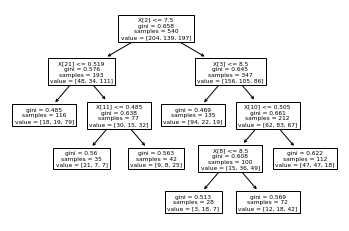

In [ ]:
tree.plot_tree(clf)
plt.show()

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree") 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=['lose','draw','win'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render(filename='plot.dot')

'plot.dot.pdf'

###Tree Classifier Tuner

In [ ]:
max_depth_values = [x for x in range(2,10)]
min_samples_split_values = [2, 10, 20, 0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_leaf_values = [1, 2, 3, 4, 10, 20, 0.1, 0.2, 0.3, 0.4]
max_features_values = [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
random_state_values = [x for x in range(1,21)]
max_leaf_nodes_values=[None, 5, 10, 20, 30, 35, 40, 45, 50, 55]
min_impurity_decrease_values=[0, 0.1, 0.01, 0.001, 0.0001]                         

In [ ]:
results = pd.read_json('results.json')

In [ ]:
results = pd.DataFrame(columns=['training_acc','test_acc','max_depth','min_samples_split','min_samples_leaf','max_features_values','random_state_values'])

i = 0

for depth in tqdm(max_depth_values):
  for split in min_samples_split_values:
    for leaf in min_samples_leaf_values:
      for feature in max_features_values:
        for rand in random_state_values:
          clf = tree.DecisionTreeClassifier(max_depth = depth, min_samples_split=split, min_samples_leaf=leaf, max_features=feature, random_state=rand, max_leaf_nodes=None, min_impurity_decrease=0.0)
          clf = clf.fit(X_train, Y_train)
          train_accuracy = clf.predict(X_train) #train acc
          Y_pred = clf.predict(X_test) #test acc
          train_acc = metrics.accuracy_score(Y_train,train_accuracy)
          test_acc = metrics.accuracy_score(Y_test,Y_pred)
          results.loc[i,['training_acc','test_acc','max_depth','min_samples_split','min_samples_leaf','max_features_values','random_state_values']] = train_acc, test_acc, depth, split, leaf, feature, rand
          i+=1



  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
results2 = pd.DataFrame(columns=['training_acc','test_acc','max_features_values','random_state_values', 'max_leafe_nodes', 'min_impurity_decrease_values'])

i = 0

for max in tqdm(max_leaf_nodes_values):
  for min in min_impurity_decrease_values:
    for feature in max_features_values:
      for rand in random_state_values:
        clf = tree.DecisionTreeClassifier(max_depth = None, min_samples_split=2, min_samples_leaf=1, max_features=feature, random_state=rand, max_leaf_nodes=max, min_impurity_decrease=min)
        clf = clf.fit(X_train, Y_train)
        train_accuracy = clf.predict(X_train) #train acc
        Y_pred = clf.predict(X_test) #test acc
        train_acc = metrics.accuracy_score(Y_train,train_accuracy)
        test_acc = metrics.accuracy_score(Y_test,Y_pred)
        results2.loc[i,['training_acc','test_acc','max_features_values','random_state_values', 'max_leafe_nodes', 'min_impurity_decrease_values']] = train_acc, test_acc, feature, rand, max, min
        i+=1


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
results.sort_values(['test_acc','training_acc'],ascending=False)

,training_acc,test_acc,max_depth,min_samples_split,min_samples_leaf,max_features_values,random_state_values
114798,0.833333,0.583333,9,10.0,4.0,0.9,19
64742,0.764815,0.583333,6,2.0,4.0,0.7,3
71154,0.644444,0.583333,6,0.1,20.0,0.7,15
87154,0.644444,0.583333,7,0.1,20.0,0.7,15
103154,0.644444,0.583333,8,0.1,20.0,0.7,15
...,...,...,...,...,...,...,...
114429,0.698148,0.333333,9,10.0,3.0,0.1,10
68425,0.622222,0.327778,6,20.0,3.0,0.1,6
80638,0.709259,0.322222,7,2.0,4.0,0.1,19
80034,0.674074,0.322222,7,2.0,1.0,0.1,15


In [ ]:
results2.sort_values(['test_acc','training_acc'],ascending=False)

,training_acc,test_acc,max_features_values,random_state_values,max_feature_values,min_impurity_decrease_values
5067,0.731481,0.566667,0.3,8,35,0
5667,0.731481,0.566667,0.3,8,35,0.001
5867,0.731481,0.566667,0.3,8,35,0.0001
4067,0.72037,0.566667,0.3,8,30,0
4667,0.72037,0.566667,0.3,8,30,0.001
...,...,...,...,...,...,...
9431,0.377778,0.344444,0.1,12,55,0.01
9433,0.377778,0.344444,0.1,14,55,0.01
28,1.0,0.338889,0.1,9,None,0
828,1.0,0.338889,0.1,9,None,0.0001


In [ ]:
clf = clf.fit(pd.concat([X_train,X_train,X_train]), pd.concat([Y_train,Y_train,Y_train]))
prediction = clf.predict(X_test)
prediction_train = clf.predict(pd.concat([X_train,X_train,X_train]))
print("Test accuracy")
print(metrics.classification_report(Y_test,prediction))
print("Train accuracy")
print(metrics.classification_report(pd.concat([Y_train,Y_train,Y_train]),prediction_train))

Test accuracy
              precision    recall  f1-score   support

          -1       0.55      0.77      0.64        62
           0       0.50      0.08      0.14        49
           1       0.59      0.72      0.65        69

    accuracy                           0.57       180
   macro avg       0.55      0.53      0.48       180
weighted avg       0.55      0.57      0.51       180

Train accuracy
              precision    recall  f1-score   support

          -1       0.57      0.79      0.67       612
           0       0.64      0.13      0.22       417
           1       0.63      0.74      0.68       591

    accuracy                           0.60      1620
   macro avg       0.62      0.55      0.52      1620
weighted avg       0.61      0.60      0.56      1620



### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, Y_train, cv=5)
scores

array([0.58333333, 0.63888889, 0.57407407, 0.69444444, 0.65740741])

In [ ]:
from sklearn.model_selection import GridSearchCV
s_tcv = time.time()
clf = tree.DecisionTreeClassifier()
parameters = {
    'max_depth' : [x for x in range(3,10)],
    'min_samples_split' : [2, 10, 20, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_samples_leaf' : [10, 20, 0.1, 0.2, 0.3],
    'max_features' : [None, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'random_state' : [x for x in range(1,10)]
    ''
}
clg_grid = GridSearchCV(clf, parameters, verbose = 0)
clg_grid.fit(X_train,Y_train)

e_tcv = time.time()
print(e_tcv - s_tcv)

451.42187452316284


In [ ]:
clg_grid.best_params_

{'max_depth': 5,
 'max_features': 0.8,
 'min_samples_leaf': 10,
 'min_samples_split': 0.1,
 'random_state': 1}

In [ ]:
clg_grid.best_score_    #HO LETTO SU INTERNET CHE HA SENSO SPLITTARE IN TRAIN E TEST PRIMA DI FARE CV, COSÌ HAI UN DATASET DI TEST PER FARE UNA VALUTAZIONE FINALE DOPO IL RISULTATO DEL CV

0.6296296296296295

In [ ]:
#y_pred_test = clg_grid.best_estimator_.predict(X_test)
clf_app= tree.DecisionTreeClassifier(max_depth=5, max_features=0.8, min_samples_leaf=10,
                       min_samples_split=0.1, random_state=1)

clf_app.fit(X_train,Y_train)

y_pred_test = clf_app.predict(X_test) #Il best estimator con train set da 0.62 che è ottimo, ma quando lo testo con il test set da 0.46.....
print(metrics.classification_report(Y_test,y_pred_test)) #Boh da un risultato di merda non capisco perchè. (Ho usato il modo che ho scritto sopra che ho letto su internet)
#UN NOSTRO PROBLEMA ABBASTANZA GRAVE È CHE IL NOSTRO DATASET NON È BALANCED (NUMERO DI PAREGGI MOLTO MINORE RISPETTO A WIN E LOSE), DOBBIAMO RISOLVERE STA COSA PER AVERE MIGLIORI RISULTATI

              precision    recall  f1-score   support

          -1       0.55      0.61      0.58        62
           0       0.29      0.12      0.17        49
           1       0.53      0.70      0.60        69

    accuracy                           0.51       180
   macro avg       0.46      0.48      0.45       180
weighted avg       0.47      0.51      0.48       180



In [ ]:
clg_grid.best_estimator_

DecisionTreeClassifier(max_depth=8, max_features=0.4, min_samples_leaf=20,
                       random_state=4)

In [ ]:
clg_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features=0.8, min_samples_leaf=10,
                       min_samples_split=0.1, random_state=1)

In [ ]:
#clf = tree.DecisionTreeClassifier(max_depth=8, max_features=0.4, min_samples_leaf=20,
#                      random_state=4)
#clf.fit(X_train,Y_train)

#prediction = clf.predict(X_test)
print(metrics.classification_report(Y_test,y_pred))

ValueError: ignored

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=5, max_features=0.8, min_samples_leaf=10,
                       min_samples_split=0.1, random_state=1)

In [ ]:
y_pred = clg_grid.best_estimator_.predict(X)

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cf_matrix = confusion_matrix(Y, y_pred)

#labels = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’]
#labels = np.asarray(labels).reshape(2,2)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Lose','Draw', 'Win']
#sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
sns.heatmap(cf_matrix,annot=True,fmt="",cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

NameError: ignored

In [ ]:


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Lose','Draw', 'Win']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')
#plot_confusion_matrix(clf, X_test, y_test)  
#plt.show()

###Balanced Dataset

In [ ]:
tmp = dataset.sample(frac=1)
index1 = tmp[tmp.result_v == 1].head(188).index
index2 = tmp[tmp.result_v == 0].index
index3 = tmp[tmp.result_v == -1].head(188).index
index = index1.append(index2).append(index3)

In [ ]:
balanced_dataset = dataset[[(x in index) for x in dataset.index]]

In [ ]:
cols = league_df.columns[10:len(league_df.columns)-1]
Y = balanced_dataset['result_v']
X = balanced_dataset[cols]

X = split_cols(X, ['team_last_five','opp_last_five'])
X = X.drop(['team_last_five','opp_last_five'], axis = 1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [ ]:
s_tcv = time.time()
clf = tree.DecisionTreeClassifier()
parameters = {
    'max_depth' : [x for x in range(3,10)],
    'min_samples_split' : [2, 10, 20, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_samples_leaf' : [10, 20, 0.1, 0.2, 0.3],
}

'''    'max_features' : [None, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'random_state' : [x for x in range(1,10)]
}'''

clg_grid = GridSearchCV(clf, parameters, verbose = 1)
clg_grid.fit(X_train,Y_train)

e_tcv = time.time()
print(e_tcv - s_tcv)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
9.187407493591309


In [ ]:
clg_grid.best_score_

0.5286352164628227

In [ ]:
clg_grid.best_params_

{'max_depth': 4, 'min_samples_leaf': 0.1, 'min_samples_split': 2}

In [ ]:
clf_app = tree.DecisionTreeClassifier(max_depth=4, max_features=0.1, min_samples_split=2)

clf_app.fit(X_train,Y_train)

y_pred_test = clf_app.predict(X_test) 
y_pred_train = clf_app.predict(X_train)

print('Train')
print(metrics.classification_report(Y_train,y_pred_train)) 
print("Test")
print(metrics.classification_report(Y_test,y_pred_test)) 


Train
              precision    recall  f1-score   support

          -1       0.50      0.65      0.57       169
           0       0.62      0.19      0.29       161
           1       0.53      0.71      0.61       177

    accuracy                           0.53       507
   macro avg       0.55      0.52      0.49       507
weighted avg       0.55      0.53      0.49       507

Test
              precision    recall  f1-score   support

          -1       0.31      0.42      0.36        19
           0       0.33      0.07      0.12        27
           1       0.16      0.36      0.22        11

    accuracy                           0.25        57
   macro avg       0.27      0.29      0.23        57
weighted avg       0.29      0.25      0.22        57



## Random Forest

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clfr = RandomForestClassifier(n_estimators=70, min_samples_split=10, random_state=42, class_weight='balanced' )

clfr.fit(X_train,Y_train)

pred = clfr.predict(X_test)

print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

          -1       0.61      0.72      0.66        50
           0       0.42      0.21      0.28        39
           1       0.62      0.75      0.68        55

    accuracy                           0.59       144
   macro avg       0.55      0.56      0.54       144
weighted avg       0.56      0.59      0.56       144



In [ ]:
parameters = {
    'n_estimators' : [100, 120, 150, 180, 200],
    'max_depth' : [3,5,7,10,13],
    'min_samples_split' : [2, 10, 20, 0.1, 0.2],
    'min_samples_leaf' : [10, 20, 0.1],
    'max_features' : [None, 0.7, 0.8, 0.9],
    'random_state' : [x for x in range(1,4)],
    'max_leaf_nodes' : [None, 5, 10, 20, 30],
    'min_impurity_decrease' : [0,0.1,0.01,0.001],
    'class_weight' : ['balanced']
}

clfr = RandomForestClassifier()

clfr_grid = GridSearchCV(clfr, parameters, verbose = 1)
clfr_grid.fit(X_train,Y_train)



Fitting 5 folds for each of 90000 candidates, totalling 450000 fits


In [ ]:
clfr_grid.best_estimator_

In [ ]:
clfr_grid.best_score_